<h2>IMPORTAMOS LIBRERÍAS</h2>

In [9]:
import numpy as np
import obspy
import emd
import pandas as pd
from tqdm.notebook import tqdm
import os
import scipy.signal as sg
from concurrent.futures import ThreadPoolExecutor
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from IPython.display import clear_output
from torchinfo import summary

In [10]:
#Comprobamos que CUDA esté corriendo correctamente en nuestra pc
print("CUDA Available: ", torch.cuda.is_available())
print("CUDA Version: ", torch.version.cuda)
print("Device Count: ", torch.cuda.device_count())

CUDA Available:  True
CUDA Version:  12.4
Device Count:  1


<h2>PREPROCESAMIENTO<h2>

<h3>LUNA</h3>

In [11]:
# Define el directorio base para los datos.
base_dir = 'data/lunar/training'

# Construye las rutas de manera compatible con Windows y Linux.
catalogy_path = os.path.join(base_dir, 'catalogs', 'apollo12_catalog_GradeA_final.csv')
data_folder = os.path.join(base_dir, 'data', 'S12_GradeA')

# Lee el archivo del catálogo que contiene metadatos sobre el conjunto de datos (por ejemplo, nombres de archivos, etiquetas, etc.).
# catalogy contiene los tiempos de los eventos sísmicos.
# Cada línea de catalogy tiene un nombre de archivo que contiene la velocidad por tiempo, y en qué parte de la secuencia se encuentra el evento sísmico.
catalogy = pd.read_csv(catalogy_path)
indexs = catalogy.index  # Obtiene los índices de las entradas del catálogo

In [12]:
# Inicializa diccionarios para almacenar los datos de entrenamiento y validación.
training_data = {
    'data': [],
    'label': []
}

validation_data = {
    'data': [],
    'label': []
}

In [13]:
# Función de filtro pasa-banda utilizando el diseño de filtro Butterworth.
# Filtra los datos entre las frecuencias lowc y high.
def butter_bandpass_filter(data: np.array, lowcut: float, highcut: float, fs: float, order: int):
    nyquist = 0.5 * fs  # Frecuencia de Nyquist, la mitad de la tasa de muestreo
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = sg.butter(order, [low, high], btype='band', analog=False)  # Diseña el filtro pasa-banda Butterworth
    y = sg.filtfilt(b, a, data)  # Aplica el filtro a los datos usando filtrado cero-fase
    return y

In [14]:
#ORIGINAL
# Función para procesar cada archivo según el índice del catálogo.
# Devuelve una tupla de (entrada, salida), donde la entrada es el dato procesado y la salida es la etiqueta.
def process_file_moon(idx):
    fileName = catalogy.at[idx, 'filename'] + '.mseed'
    arrival_time = catalogy.at[idx, 'time_rel(sec)']

    # Verifica si el archivo existe, si no, devuelve None.
    if not os.path.exists(os.path.join(data_folder, fileName)):
        return None, None

    # Lee el archivo de datos sísmicos y lo preprocesa.
    stream = obspy.read(os.path.join(data_folder, fileName))
    data = stream[0].data
    time = stream[0].times()
    fs = stream[0].stats.sampling_rate

    # Encuentra el índice del tiempo de llegada en los datos.
    arrival_idx = np.where(time >= arrival_time)[0][0]

    # Define el tamaño de la ventana para el segmento de datos.
    window_size_sec = 30 * 60
    window_size = int(window_size_sec * fs)

    # Aplica un filtro pasa banda a los datos.
    data = butter_bandpass_filter(data, 0.4, 1, fs, 6)

    # Realiza una Descomposición Empírica de Modo (EMD) en los datos.
    imfs = emd.sift.ensemble_sift(data, max_imfs=5)
    stride = window_size // 48
    input = np.lib.stride_tricks.sliding_window_view(imfs**2, window_shape=window_size, axis=0)[::stride, :, :]
    input = np.sum(input, axis=-1)

    # Inicializa el arreglo de salida.
    output = np.zeros((data.shape[0],))

    # Define la ventana gaussiana para la etiqueta de salida.
    arrival_idx = np.where(time - window_size_sec / 4 >= arrival_time)[0][0]
    sigma = window_size / 8 * 1.5
    gaussian_window_size = int(window_size * 1.5)
    if gaussian_window_size % 2 == 1: gaussian_window_size += 1
    gaussian_window = sg.windows.gaussian(gaussian_window_size, std=sigma)
    left_idx = arrival_idx - (gaussian_window_size // 2)
    right_idx = arrival_idx + (gaussian_window_size // 2)

    # Ajusta los índices para que se ajusten dentro de los límites del arreglo de salida.
    if left_idx < 0:
        left_idx = 0
    if right_idx > len(output):
        right_idx = len(output)

    # Asigna la ventana gaussiana al arreglo de salida.
    output[left_idx:right_idx] = gaussian_window[:right_idx - left_idx]

    # Vuelve a muestrear la entrada y salida a un tamaño fijo.
    input = sg.resample(input, 4000, axis=0)
    output = sg.resample(output, 4000)

    # Normaliza los datos de entrada.
    input_maxs = np.max(input, axis=0)
    input = input / input_maxs

    # Asegura que la entrada tenga al menos 5 canales.
    while input.shape[1] < 5:
        input = np.concatenate([input, np.zeros((input.shape[0], 1)) + 0.001], axis=1)

    return input, output

In [15]:
# Define los índices para los conjuntos de validación y entrenamiento.
indexs_validation = [7, 8, 22, 23, 27, 34, 36, 37, 40, 48, 49, 67, 68]
indexs_train = [i for i in indexs if i not in indexs_validation]

In [16]:
# Procesar los archivos de entrenamiento en paralelo utilizando múltiples hilos (threads).
# Se usa `ThreadPoolExecutor` para paralelizar el procesamiento y mejorar la velocidad.
with ThreadPoolExecutor(max_workers=os.cpu_count() - 2) as executor:
    # Se aplica la función `process_file_moon` a cada índice en `indexs_train` y se muestra un progreso con tqdm.
    results = list(tqdm(executor.map(process_file_moon, indexs_train), total=len(indexs_train)))

# Recopilar los datos procesados de entrenamiento.
for r in results:
    # Si el archivo no pudo procesarse (devuelve `None`), se imprime "skip" y se pasa al siguiente.
    if r[0] is None:
        print('skip')
        continue
    # Se agrega el dato procesado (entrada) a la lista `training_data['data']`.
    training_data['data'].append(r[0])
    # Se agrega la etiqueta correspondiente (salida) a la lista `training_data['label']`.
    training_data['label'].append(r[1])

# Procesar los archivos de validación en paralelo utilizando múltiples hilos (threads).
with ThreadPoolExecutor(max_workers=os.cpu_count() - 2) as executor:
    # Similar al procesamiento de entrenamiento, pero aplicado a los índices de validación.
    results = list(tqdm(executor.map(process_file_moon, indexs_validation), total=len(indexs_validation)))

# Recopilar los datos procesados de validación.
for r in results:
    # Si el archivo no pudo procesarse, se imprime "skip" y se pasa al siguiente.
    if r[0] is None:
        print('skip')
        continue
    # Se agrega el dato procesado (entrada) a la lista `validation_data['data']`.
    validation_data['data'].append(r[0])
    # Se agrega la etiqueta correspondiente (salida) a la lista `validation_data['label']`.
    validation_data['label'].append(r[1])

# Mostrar las dimensiones del primer dato de entrada procesado.
inp, out = results[0]  # Se obtiene el primer par de entrada y salida de los resultados procesados.
print(inp.shape)       # Se imprime la forma (shape) de la entrada procesada para verificar sus dimensiones.

  0%|          | 0/63 [00:00<?, ?it/s]

skip


  0%|          | 0/13 [00:00<?, ?it/s]

(4000, 5)


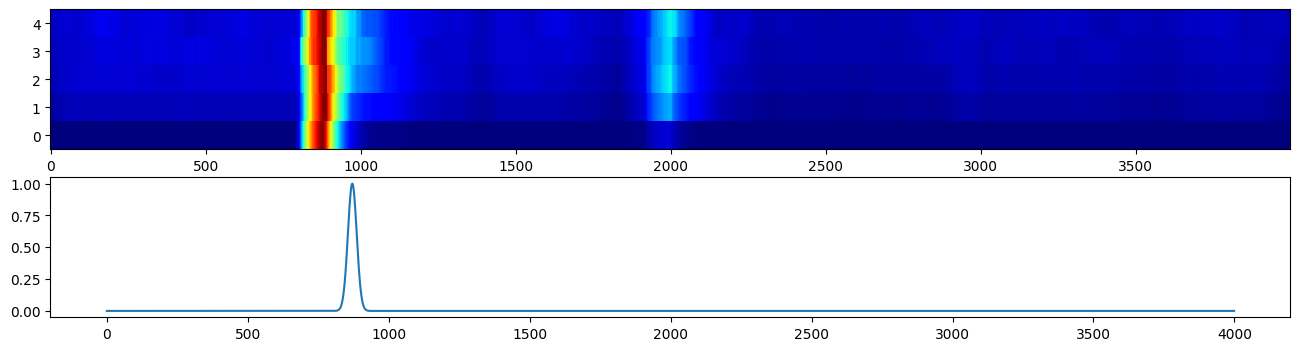

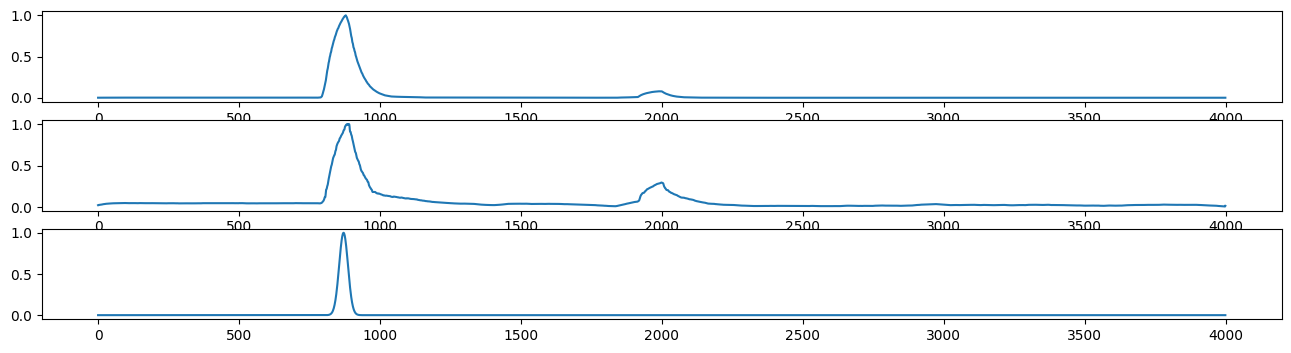

In [17]:
# Grafica la primera entrada procesada y su salida.
fig, axs = plt.subplots(2, 1, figsize=(16, 4))
axs[0].imshow(inp.T, aspect='auto', cmap='jet', interpolation='nearest', origin='lower')
axs[1].plot(out)

# Grafica los canales individuales de la primera entrada procesada y la salida.
fig, axs = plt.subplots(3, 1, figsize=(16, 4))
axs[0].plot(inp[:, 0])
axs[1].plot(inp[:, 1])
axs[2].plot(out)

<h3>MARTE</h3>

  0%|          | 0/2 [00:00<?, ?it/s]

(4000, 5)


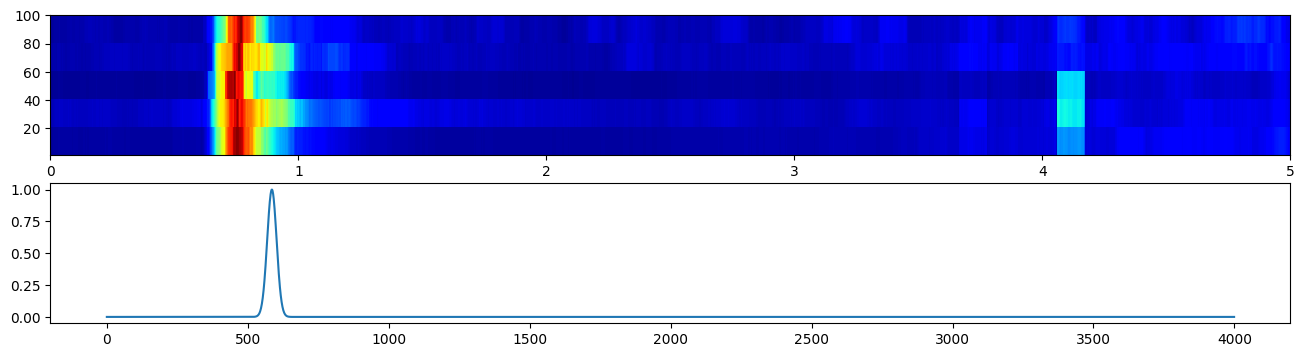

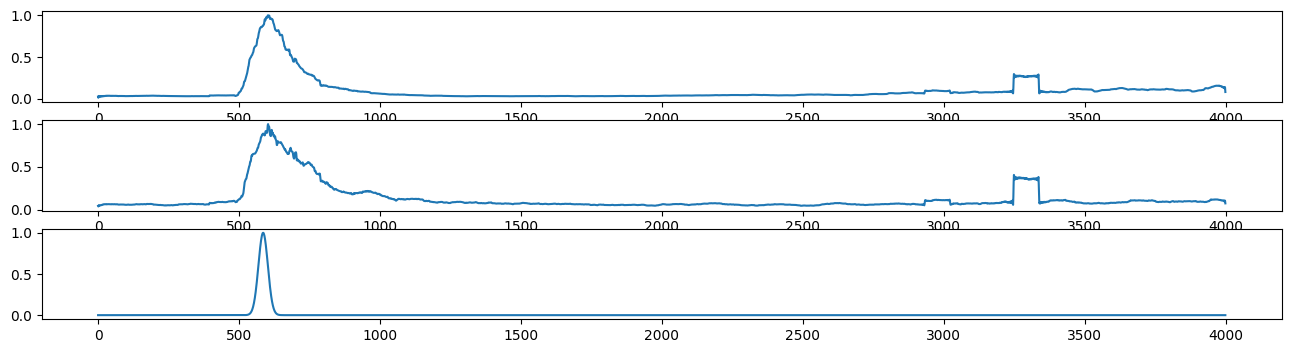

In [18]:
# Define el directorio base para los datos.
base_dir_mars = 'data/mars/training'

# Construye las rutas de acceso de forma compatible con Windows y Linux.
catalogy_path_mars = os.path.join(base_dir_mars, 'catalogs', 'Mars_InSight_training_catalog_final.csv')
data_folder_mars = os.path.join(base_dir_mars, 'data')

# Lee el archivo del catálogo, que contiene metadatos sobre el conjunto de datos (por ejemplo, nombres de archivos, etiquetas, etc.).
# catalogy contiene los tiempos de los eventos sísmicos.
# Cada línea de catalogy tiene un nombre de archivo que tiene la velocidad por tiempo y el evento sísmico correspondiente en la secuencia.
catalogy_mars = pd.read_csv(catalogy_path_mars)
indexs_mars = catalogy_mars.index  # Obtiene los índices de las entradas del catálogo

# Inicializa un diccionario para almacenar los datos de validación.
validation_data_mars = {
    "data": [],  # Lista para almacenar los datos de entrada
    "label": []  # Lista para almacenar las etiquetas de los eventos sísmicos
}

# Función para procesar un archivo dado su índice en el catálogo.
def process_file_mars(idx):
    # Obtiene el nombre del archivo y el tiempo de llegada del catálogo.
    fileName = catalogy_mars.at[idx, 'filename'].replace(".csv", "") + '.mseed'
    arrival_time = catalogy_mars.at[idx, 'time_rel(sec)']

    # Verifica si el archivo existe.
    if not os.path.exists(os.path.join(data_folder_mars, fileName)):
        return None, None

    # Lee el archivo de datos sísmicos y realiza el preprocesamiento.
    stream = obspy.read(os.path.join(data_folder_mars, fileName))
    data = stream[0].data  # Datos sísmicos
    time = stream[0].times()  # Tiempos de los datos sísmicos
    fs = stream[0].stats.sampling_rate  # Frecuencia de muestreo

    # Encuentra el índice del tiempo de llegada del evento sísmico.
    arrival_idx = np.where(time >= arrival_time)[0][0]

    # Define el tamaño de la ventana para el procesamiento.
    window_size_sec = 80  # Ventana de 80 segundos
    window_size = int(window_size_sec * fs)  # Tamaño de la ventana en muestras

    # Aplica un filtro paso banda a los datos.
    data = butter_bandpass_filter(data, 2, 8, fs, 6)

    # Realiza la descomposición en modos empíricos (EEMD) sobre los datos.
    imfs = emd.sift.ensemble_sift(data, max_imfs=5)
    stride = window_size // 48  # Define el paso de la ventana deslizante
    input = np.lib.stride_tricks.sliding_window_view(imfs**2, window_shape=window_size, axis=0)[::stride, :, :]  # Ventana deslizante
    input = np.sum(input, axis=-1)  # Suma las ventanas deslizantes a lo largo del último eje

    # Inicializa el arreglo de salida.
    output = np.zeros((data.shape[0], ))  # La salida será una señal con el mismo tamaño que los datos

    # Ajusta el índice de llegada con el tamaño de la ventana.
    arrival_idx = np.where(time - window_size_sec / 4 >= arrival_time)[0][0]
    sigma = window_size / 8 * 1.5  # Parámetro para la ventana gaussiana
    gaussian_window_size = int(window_size * 1.5)  # Tamaño de la ventana gaussiana
    if gaussian_window_size % 2 == 1: gaussian_window_size += 1  # Asegura que el tamaño sea par
    gaussian_window = sg.windows.gaussian(gaussian_window_size, std=sigma)  # Genera la ventana gaussiana
    left_idx = arrival_idx - (gaussian_window_size // 2)  # Índice izquierdo de la ventana gaussiana
    right_idx = arrival_idx + (gaussian_window_size // 2)  # Índice derecho de la ventana gaussiana

    # Ajusta los índices si están fuera de los límites de los datos.
    if left_idx < 0:
        left_idx = 0
    if right_idx > len(output):
        right_idx = len(output)

    # Aplica la ventana gaussiana a la salida.
    output[left_idx:right_idx] = gaussian_window[:right_idx - left_idx]

    # Realiza el re-muestreo de las entradas y las salidas.
    input = sg.resample(input, 4000, axis=0)  # Re-muestreo de los datos de entrada
    output = sg.resample(output, 4000)  # Re-muestreo de las etiquetas de salida

    # Normaliza los datos de entrada.
    input_maxs = np.max(input, axis=0)  # Encuentra el valor máximo en cada columna
    input = input / input_maxs  # Normaliza los datos dividiendo por el máximo de cada columna

    # Asegura que los datos de entrada tengan al menos 5 columnas.
    while input.shape[1] < 5:
        input = np.concatenate([input, np.zeros((input.shape[0], 1)) + 0.001], axis=1)  # Rellena con valores pequeños si es necesario

    return input, output

# Divide aleatoriamente los índices en conjuntos de entrenamiento y prueba.
# Hay 76 archivos en el catálogo; en este caso, se usan 66 para entrenamiento y 10 para validación.
indexs_validation_mars = [0, 1]

# Descomenta el siguiente código para procesar todos los índices de entrenamiento en paralelo usando múltiples hilos:
with ThreadPoolExecutor(max_workers=os.cpu_count() - 2) as executor:
    results_mars = list(tqdm(executor.map(process_file_mars, indexs_validation_mars), total=len(indexs_validation_mars)))

# Agrega los datos procesados al diccionario de datos de validación.
for r in results_mars:
    if r[0] is None:
        print('skip')  # Si no se pudo procesar el archivo, lo omite
        continue
    validation_data_mars['data'].append(r[0])  # Agrega los datos procesados
    validation_data_mars['label'].append(r[1])  # Agrega las etiquetas procesadas

# Obtiene el primer resultado para visualizarlo.
inp, out = results_mars[0]
print(inp.shape)

# Grafica los datos de entrada y salida.
fig, axs = plt.subplots(2, 1, figsize=(16, 4))
axs[0].imshow(inp.T, aspect='auto', cmap='jet', interpolation='nearest', origin='lower', extent=[0, inp.shape[1], 1, 100], vmin=0, vmax=inp.max())  # Muestra los datos de entrada
axs[1].plot(out)  # Muestra las etiquetas de salida

# Grafica componentes individuales de los datos de entrada.
fig, axs = plt.subplots(3, 1, figsize=(16, 4))
axs[0].plot(inp[:, 0])  # Muestra la primera componente de entrada
axs[1].plot(inp[:, 1])  # Muestra la segunda componente de entrada
axs[2].plot(out)  # Muestra las etiquetas de salida


<h3>ORGANIZACIÓN DE DATOS</h3>

In [19]:
# Convertir las listas en arreglos de numpy:
# Luna:
training_data['data'] = np.array(training_data['data'])  # Convierte los datos de entrenamiento en un arreglo numpy
training_data['label'] = np.array(training_data['label'])  # Convierte las etiquetas de entrenamiento en un arreglo numpy

validation_data['data'] = np.array(validation_data['data'])  # Convierte los datos de validación en un arreglo numpy
validation_data['label'] = np.array(validation_data['label'])  # Convierte las etiquetas de validación en un arreglo numpy

# Marte:
validation_data_mars['data'] = np.array(validation_data_mars['data'])  # Convierte los datos de validación de Marte en un arreglo numpy
validation_data_mars['label'] = np.array(validation_data_mars['label'])  # Convierte las etiquetas de validación de Marte en un arreglo numpy

# Transponer los datos para tener la forma correcta:
# Luna:
X_train = training_data['data'].transpose(0, 2, 1)  # Transpone los datos de entrenamiento para que las dimensiones sean adecuadas
Y_train = training_data['label'][:, np.newaxis, :]  # Ajusta las etiquetas de entrenamiento para agregar una nueva dimensión

X_eval = validation_data['data'].transpose(0, 2, 1)  # Transpone los datos de validación para que las dimensiones sean adecuadas
Y_eval = validation_data['label'][:, np.newaxis, :]  # Ajusta las etiquetas de validación para agregar una nueva dimensión

# Marte:
X_eval_mars = validation_data_mars['data'].transpose(0, 2, 1)  # Transpone los datos de validación de Marte para que las dimensiones sean adecuadas
Y_eval_mars = validation_data_mars['label'][:, np.newaxis, :]  # Ajusta las etiquetas de validación de Marte para agregar una nueva dimensión


<h3>Funciones</h3>

In [20]:
import torch

# Importar las bibliotecas necesarias
import torch.nn as nn

# Definir un bloque convolucional con normalización por lotes y activación ReLU
class conbr_block(nn.Module):
    def __init__(self, in_layer, out_layer, kernel_size, stride, dilation):
        super(conbr_block, self).__init__()
        self.conv1 = nn.Conv1d(in_layer, out_layer, kernel_size=kernel_size, stride=stride, dilation=dilation, padding=3, bias=True)  # Capa convolucional 1D
        self.bn = nn.BatchNorm1d(out_layer)  # Capa de normalización por lotes
        self.relu = nn.ReLU()  # Función de activación ReLU
    
    def forward(self, x):
        x = self.conv1(x)  # Aplicar convolución
        x = self.bn(x)  # Normalización por lotes
        out = self.relu(x)  # Aplicar ReLU
        return out       

# Definir un bloque de compresión y excitación (Squeeze-and-Excitation)
class se_block(nn.Module):
    def __init__(self, in_layer, out_layer):
        super(se_block, self).__init__()
        self.conv1 = nn.Conv1d(in_layer, out_layer // 8, kernel_size=1, padding=0)  # Convención 1x1
        self.conv2 = nn.Conv1d(out_layer // 8, in_layer, kernel_size=1, padding=0)  # Convención 1x1
        self.fc = nn.Linear(1, out_layer // 8)  # Capa densa
        self.fc2 = nn.Linear(out_layer // 8, out_layer)  # Capa densa
        self.relu = nn.ReLU()  # Función de activación ReLU
        self.sigmoid = nn.Sigmoid()  # Función de activación Sigmoid
    
    def forward(self, x):
        x_se = nn.functional.adaptive_avg_pool1d(x, 1)  # Promedio adaptativo
        x_se = self.conv1(x_se)  # Conv1
        x_se = self.relu(x_se)  # ReLU
        x_se = self.conv2(x_se)  # Conv2
        x_se = self.sigmoid(x_se)  # Sigmoid
        x_out = torch.add(x, x_se)  # Sumar el tensor original con el tensor de excitación
        return x_out

# Definir un bloque residual con bloques convolucionales y de compresión y excitación
class re_block(nn.Module):
    def __init__(self, in_layer, out_layer, kernel_size, dilation):
        super(re_block, self).__init__()
        self.cbr1 = conbr_block(in_layer, out_layer, kernel_size, 1, dilation)  # Primer bloque convolucional
        self.cbr2 = conbr_block(out_layer, out_layer, kernel_size, 1, dilation)  # Segundo bloque convolucional
        self.seblock = se_block(out_layer, out_layer)  # Bloque SE
    
    def forward(self, x):
        x_re = self.cbr1(x)  # Aplicar primer bloque convolucional
        x_re = self.cbr2(x_re)  # Aplicar segundo bloque convolucional
        x_re = self.seblock(x_re)  # Aplicar bloque SE
        x_out = torch.add(x, x_re)  # Sumar la entrada con la salida del bloque residual
        return x_out          

# Definir el modelo UNET
class UNET(nn.Module):
    def __init__(self, input_dim, layer_n, kernel_size, depth):
        super(UNET, self).__init__()
        self.input_dim = input_dim
        self.layer_n = layer_n
        self.kernel_size = kernel_size
        self.depth = depth
        
        # Definir capas de promedio de agrupamiento (pooling)
        self.AvgPool1D1 = nn.AvgPool1d(input_dim, stride=5)
        self.AvgPool1D2 = nn.AvgPool1d(input_dim, stride=25)
        self.AvgPool1D3 = nn.AvgPool1d(input_dim, stride=125)
        
        # Definir capas de submuestreo (downsampling)
        self.layer1 = self.down_layer(self.input_dim, self.layer_n, self.kernel_size, 1, 2)
        self.layer2 = self.down_layer(self.layer_n, int(self.layer_n * 2), self.kernel_size, 5, 2)
        self.layer3 = self.down_layer(int(self.layer_n * 2) + int(self.input_dim), int(self.layer_n * 3), self.kernel_size, 5, 2)
        self.layer4 = self.down_layer(int(self.layer_n * 3) + int(self.input_dim), int(self.layer_n * 4), self.kernel_size, 5, 2)
        self.layer5 = self.down_layer(int(self.layer_n * 4) + int(self.input_dim), int(self.layer_n * 5), self.kernel_size, 4, 2)

        # Definir capas de sobre-muestreo (upsampling)
        self.cbr_up1 = conbr_block(int(self.layer_n * 7), int(self.layer_n * 3), self.kernel_size, 1, 1)
        self.cbr_up2 = conbr_block(int(self.layer_n * 5), int(self.layer_n * 2), self.kernel_size, 1, 1)
        self.cbr_up3 = conbr_block(int(self.layer_n * 3), self.layer_n, self.kernel_size, 1, 1)
        self.upsample = nn.Upsample(scale_factor=5, mode='nearest')  # Upsampling usando el método de vecinos más cercanos
        self.upsample1 = nn.Upsample(scale_factor=5, mode='nearest')
        
        # Capa convolucional de salida
        self.outcov = nn.Conv1d(self.layer_n, 1, kernel_size=self.kernel_size, stride=1, padding=3)
    
    # Definir un método para crear las capas de submuestreo (downsampling)
    def down_layer(self, input_layer, out_layer, kernel, stride, depth):
        block = []
        block.append(conbr_block(input_layer, out_layer, kernel, stride, 1))  # Agregar primer bloque convolucional
        for i in range(depth):  # Agregar bloques residuales
            block.append(re_block(out_layer, out_layer, kernel, 1))
        return nn.Sequential(*block)
            
    def forward(self, x):
        # Aplicar capas de promedio de agrupamiento (pooling)
        pool_x1 = self.AvgPool1D1(x)
        pool_x2 = self.AvgPool1D2(x)
        pool_x3 = self.AvgPool1D3(x)
        
        # Codificador (Encoder)
        out_0 = self.layer1(x)
        out_1 = self.layer2(out_0)
        
        # Concatenar las características agrupadas con las características codificadas
        x = torch.cat([out_1, pool_x1], 1)
        out_2 = self.layer3(x)

        x = torch.cat([out_2, pool_x2], 1)
        x = self.layer4(x)
        
        # Decodificador (Decoder)
        up = self.upsample1(x)
        up = torch.cat([up, out_2], 1)
        up = self.cbr_up1(up)
        
        up = self.upsample(up)
        up = torch.cat([up, out_1], 1)
        up = self.cbr_up2(up)
        
        up = self.upsample(up)
        up = torch.cat([up, out_0], 1)
        up = self.cbr_up3(up)
        
        # Capa de salida
        out = self.outcov(up)
        
        # Aplicar softmax (comentado)
        # out = nn.functional.softmax(out, dim=2)
        
        return out




<h3>Entrenamiento</h3>

In [22]:
# Establecer el dispositivo a GPU si está disponible
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # Si hay una GPU disponible, usa 'cuda', si no, usa 'cpu'
torch.set_default_device(device)  # Establece el dispositivo por defecto para PyTorch
if device == 'cuda':
    print("El entrenamiento se realizará en GPU.")
else:
    print("El entrenamiento se realizará en CPU.")

# ============== Convertir arrays de numpy a tensores y moverlos a la GPU ==============

# Moon:
X_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)  # Convierte los datos de entrenamiento de numpy a tensor y los mueve a la GPU
Y_tensor = torch.tensor(Y_train, dtype=torch.float32).to(device)  # Convierte las etiquetas de entrenamiento de numpy a tensor y las mueve a la GPU

X_eval_tensor = torch.tensor(X_eval, dtype=torch.float32).to(device)  # Convierte los datos de validación de numpy a tensor y los mueve a la GPU
Y_eval_tensor = torch.tensor(Y_eval, dtype=torch.float32).to(device)  # Convierte las etiquetas de validación de numpy a tensor y las mueve a la GPU

# Imprime las formas de los tensores para comprobar que se han convertido correctamente
print(f'X_tensor shape: {X_tensor.shape}')
print(f'Y_tensor shape: {Y_tensor.shape}')

print(f'\nX_eval_tensor shape: {X_eval_tensor.shape}')
print(f'Y_eval_tensor shape: {Y_eval_tensor.shape}')

# Mars:
X_eval_mars_tensor = torch.tensor(X_eval_mars, dtype=torch.float32).to(device)  # Convierte los datos de validación de Marte a tensor y los mueve a la GPU
Y_eval_mars_tensor = torch.tensor(Y_eval_mars, dtype=torch.float32).to(device)  # Convierte las etiquetas de validación de Marte a tensor y las mueve a la GPU

# Imprime las formas de los tensores para los datos de Marte
print(f'\nX_eval_mars_tensor shape: {X_eval_mars_tensor.shape}')
print(f'Y_eval_mars_tensor shape: {Y_eval_mars_tensor.shape}')

# ================================== HECHO ====================================


# ================= Crear DataLoaders con los conjuntos de datos ===================

generator = torch.Generator(device=device)  # Asegura que el DataLoader use un generador en la GPU

# Moon:
dataset = TensorDataset(X_tensor, Y_tensor)  # Crea un dataset para entrenamiento con los datos de la luna
eval_dataset = TensorDataset(X_eval_tensor, Y_eval_tensor)  # Crea un dataset para validación con los datos de la luna

train_loader = DataLoader(dataset, batch_size=2, shuffle=True, generator=generator)  # Crea el DataLoader para entrenamiento
eval_loader = DataLoader(eval_dataset, batch_size=2, shuffle=False, generator=generator)  # Crea el DataLoader para validación

# Mars:
eval_mars_dataset = TensorDataset(X_eval_mars_tensor, Y_eval_mars_tensor)  # Crea un dataset para validación con los datos de Marte
eval_loader_mars = DataLoader(eval_mars_dataset, batch_size=2, shuffle=False, generator=generator)  # Crea el DataLoader para validación de Marte

# ============================ DataLoaders creados ============================

# ============================ Configuración del modelo y entrenamiento ========================

# Inicializar el modelo y moverlo a la GPU
model = model = UNET(5,128,7,3).to(device)  # Inicializa el modelo y lo mueve a la GPU

# Configurar el optimizador y la función de pérdida
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)  # Optimiza con AdamW, con decaimiento de peso

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.8, min_lr=1e-8)  # Scheduler para reducir la tasa de aprendizaje si la pérdida no mejora

criterion = nn.MSELoss()  # Función de pérdida MSE para clasificación binaria

# Configuración para el early stopping
patience = 100  # Número de épocas a esperar antes de detenerse si no hay mejora
min_delta = 0.0001  # Mínima mejora en la pérdida para considerar que hubo una mejora
best_loss = float('inf')  # Inicializa la mejor pérdida con un valor alto
patience_counter = 0  # Contador para el early stopping

# ============================ Configuración terminada =====================


El entrenamiento se realizará en GPU.
X_tensor shape: torch.Size([62, 5, 4000])
Y_tensor shape: torch.Size([62, 1, 4000])

X_eval_tensor shape: torch.Size([13, 5, 4000])
Y_eval_tensor shape: torch.Size([13, 1, 4000])

X_eval_mars_tensor shape: torch.Size([2, 5, 4000])
Y_eval_mars_tensor shape: torch.Size([2, 1, 4000])


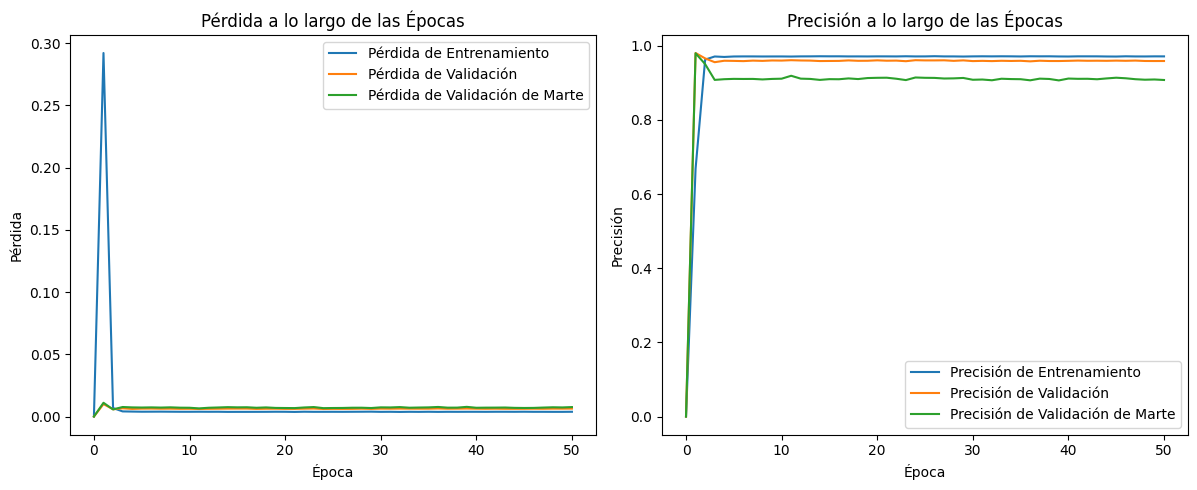

Época 50/50
Pérdida de Entrenamiento en la Luna: 0.0038, Precisión de Entrenamiento en la Luna: 0.9714
Pérdida de Validación en la Luna: 0.0064, Precisión de Validación en la Luna: 0.9589
Pérdida de Validación en Marte: 0.0076, Precisión de Validación en Marte: 0.9077


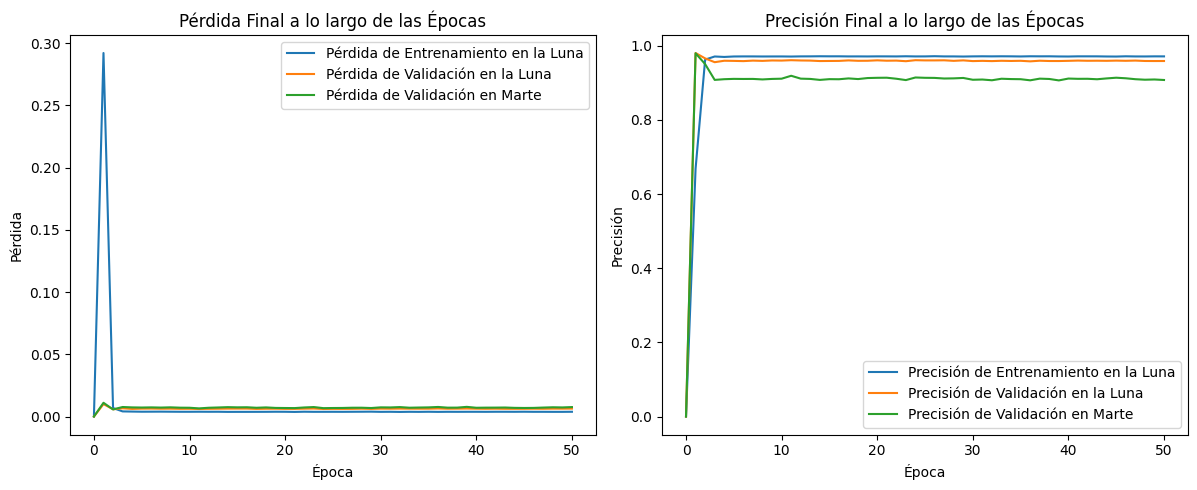

Resultados:
      - Pérdida de Entrenamiento en la Luna: 0.0038
      - Precisión de Entrenamiento en la Luna: 0.9714
                - 
      - Pérdida de Validación en la Luna: 0.0064
      - Precisión de Validación en la Luna: 0.9589
                - 
      - Pérdida de Validación en Marte: 0.0076
      - Precisión de Validación en Marte: 0.9077


In [23]:
# Número de épocas para entrenar
num_epochs = 50

# Listas para almacenar las métricas
train_losses = [0]
train_accuracies = [0]
val_losses = [0]
val_accuracies = [0]
val_losses_mars = [0]
val_accuracies_mars = [0]

# Bucle de entrenamiento
for epoch in range(num_epochs):

    # Establecer el modelo en modo de entrenamiento
    model.train()

    # Inicializando las métricas para la época:
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    # Iterar a través de los datos de entrenamiento
    for inputs, labels in train_loader:

        # Mover los datos al dispositivo
        inputs, labels = inputs.to(device), labels.to(device)

        # Poner a cero los gradientes de los parámetros
        optimizer.zero_grad()

        # Paso hacia adelante
        outputs = model(inputs)

        # Pérdida MSE:
        loss = criterion(outputs, labels)

        # Paso hacia atrás
        loss.backward()

        # Actualizar los pesos
        optimizer.step()

        # Actualizar la tasa de aprendizaje
        scheduler.step(loss)

        # Rastrear la pérdida acumulada
        running_loss += loss.item()

        # Calcular precisión
        correct_predictions += torch.sum(torch.abs(outputs - labels) < 0.1).item()
        total_predictions += torch.numel(outputs)


    # Calcular la pérdida y precisión promedio del entrenamiento para la época
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Evaluar el modelo en el conjunto de validación para cada época
    model.eval()  # Establecer el modelo en modo de evaluación
    val_running_loss = 0.0
    val_correct_predictions = 0
    val_total_predictions = 0
    with torch.no_grad():  # Desactivar el cálculo de gradientes
        for inputs, labels in eval_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Mover los datos al dispositivo
            outputs = model(inputs)  # Paso hacia adelante
            eval_loss = criterion(outputs, labels)  # Calcular pérdida
            val_running_loss += eval_loss.item()

            # Calcular precisión
            val_correct_predictions += torch.sum(torch.abs(outputs - labels) < 0.1).item()
            val_total_predictions += torch.numel(outputs)

    # Calcular la pérdida y precisión promedio de la validación para la época
    val_epoch_loss = val_running_loss / len(eval_loader)
    val_epoch_accuracy = val_correct_predictions / val_total_predictions
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_accuracy)

    # Evaluar el modelo en el conjunto de validación de Marte para cada época
    val_running_loss_mars = 0.0
    val_correct_predictions_mars = 0
    val_total_predictions_mars = 0

    with torch.no_grad():  # Desactivar el cálculo de gradientes
        for inputs, labels in eval_loader_mars:
            inputs, labels = inputs.to(device), labels.to(device)  # Mover los datos al dispositivo
            outputs = model(inputs)  # Paso hacia adelante
            eval_loss = criterion(outputs, labels)  # Calcular pérdida
            val_running_loss_mars += eval_loss.item()

            # Calcular precisión
            val_correct_predictions_mars += torch.sum(torch.abs(outputs - labels) < 0.1).item()
            val_total_predictions_mars += torch.numel(outputs)

    # Calcular la pérdida y precisión promedio de la validación de Marte para la época
    val_epoch_loss_mars = val_running_loss_mars / len(eval_loader_mars)
    val_epoch_accuracy_mars = val_correct_predictions_mars / val_total_predictions_mars
    val_losses_mars.append(val_epoch_loss_mars)
    val_accuracies_mars.append(val_epoch_accuracy_mars)

    # Limpiar la salida y graficar
    clear_output(wait=True)

    # Graficar las métricas
    plt.figure(figsize=(18, 5))

    # Graficar la Pérdida
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Pérdida de Entrenamiento')
    plt.plot(val_losses, label='Pérdida de Validación')
    plt.plot(val_losses_mars, label='Pérdida de Validación de Marte')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.title('Pérdida a lo largo de las Épocas')
    plt.legend()

    # Graficar la Precisión
    plt.subplot(1, 3, 2)
    plt.plot(train_accuracies, label='Precisión de Entrenamiento')
    plt.plot(val_accuracies, label='Precisión de Validación')
    plt.plot(val_accuracies_mars, label='Precisión de Validación de Marte')
    plt.xlabel('Época')
    plt.ylabel('Precisión')
    plt.title('Precisión a lo largo de las Épocas')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Imprimir las métricas actuales
    print(f"Época {epoch+1}/{num_epochs}")
    print(f"Pérdida de Entrenamiento en la Luna: {epoch_loss:.4f}, Precisión de Entrenamiento en la Luna: {epoch_accuracy:.4f}")
    print(f"Pérdida de Validación en la Luna: {val_epoch_loss:.4f}, Precisión de Validación en la Luna: {val_epoch_accuracy:.4f}")
    print(f"Pérdida de Validación en Marte: {val_epoch_loss_mars:.4f}, Precisión de Validación en Marte: {val_epoch_accuracy_mars:.4f}")

# Después de que finalice el entrenamiento
# Graficar las métricas finales
plt.figure(figsize=(18, 5))

# Graficar la Pérdida
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Pérdida de Entrenamiento Luna')
plt.plot(val_losses, label='Pérdida de Validación Luna')
plt.plot(val_losses_mars, label='Pérdida de Validación en Marte')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Pérdida Final a lo largo de las Épocas')
plt.legend()

# Graficar la Precisión
plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Precisión de Entrenamiento Luna')
plt.plot(val_accuracies, label='Precisión de Validación Luna')
plt.plot(val_accuracies_mars, label='Precisión de Validación en Marte')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.title('Precisión Final a lo largo de las Épocas')
plt.legend()

plt.tight_layout()
plt.show()

# Imprimir resultados finales
print("""Resultados:
      - Pérdida de Entrenamiento en la Luna: {:.4f}
      - Precisión de Entrenamiento en la Luna: {:.4f}
                - 
      - Pérdida de Validación en la Luna: {:.4f}
      - Precisión de Validación en la Luna: {:.4f}
                - 
      - Pérdida de Validación en Marte: {:.4f}
      - Precisión de Validación en Marte: {:.4f}""".format(
          epoch_loss, epoch_accuracy, val_epoch_loss, val_epoch_accuracy, val_epoch_loss_mars, val_epoch_accuracy_mars))

# Guardar el modelo
torch.save(model.state_dict(), 'model.pth')
